In [8]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt 

DATA_FILE = Path('weather.csv')  # preferred filename
SAMPLE_FILE = Path('sample_weather.csv')

pd.options.display.max_rows = 20
pd.options.display.max_columns = 10

In [9]:
path=DATA_FILE
if not path.exists():
    if SAMPLE_FILE.exists():
        df = pd.read_csv(SAMPLE_FILE)
        df.to_csv(path, index=False)
        print("No weather.csv found — copied sample_weather.csv to weather.csv")
    else:
        raise FileNotFoundError("No weather.csv or sample_weather.csv found in folder.")

df=pd.read_csv("weather.csv")

#standardized columns
df.columns=[c.strip().lower() for c in df.columns]

#parse date
if 'date' in df.columns:
    df['date']=pd.to_datetime(df["date"],errors="coerce")

# ✅ Convert selected columns into numeric
for col in ['temp','humidity']:
    if col in df.columns:
        df[col]=pd.to_numeric(df[col],errors="coerce" )
print("loaded data:",len(df))
df.head()

loaded data: 45


,date,city,temp,humidity
0,2025-01-27,Bengaluru,NaN,49.4
1,2025-01-24,Mumbai,26.8,86.8
2,2025-01-17,Bengaluru,31.5,78.0
3,2025-02-16,Mumbai,34.9,40.8
4,2025-01-14,Bengaluru,NaN,50.9


## 3) Inspect missing values

Show how many missing values exist per column.

In [10]:
missing_summary=df.isna().sum()
print(missing_summary)

df[df.isna().any(axis=1)].head(10)

date         0
city         0
temp        10
humidity     6
dtype: int64


,date,city,temp,humidity
0,2025-01-27,Bengaluru,NaN,49.4
4,2025-01-14,Bengaluru,NaN,50.9
5,2025-01-30,Delhi,NaN,74.9
6,2025-01-27,Mumbai,NaN,40.6
7,2025-02-07,Mumbai,32.6,NaN
13,2025-02-15,Delhi,NaN,89.8
15,2025-01-31,Bengaluru,NaN,51.2
18,2025-01-14,Mumbai,19.1,NaN
20,2025-03-01,Mumbai,35.3,NaN
34,2025-02-22,Delhi,26.5,NaN


## 4) Handle missing values

Strategy used here:
- For `temp`: fill missing values with **mean temperature per city** (fallback to global mean if city mean is NaN).
- For `humidity`: fill missing values with **median humidity per city** (fallback to global median if needed).

You can change strategies (drop, forward-fill, interpolation) depending on your use-case.

In [11]:
# Fill missing temp by city mean, fallback to global mean
if 'temp' in df.columns and 'city' in df.columns:
    city_temp_mean = df.groupby('city')['temp'].transform('mean')
    global_temp_mean = df['temp'].mean()
    df['temp'] = df['temp'].fillna(city_temp_mean)
    df['temp'] = df['temp'].fillna(global_temp_mean)

# Fill missing humidity by city median
if 'humidity' in df.columns and 'city' in df.columns:
    city_hum_median = df.groupby('city')['humidity'].transform('median')
    global_hum_median = df['humidity'].median()
    df['humidity'] = df['humidity'].fillna(city_hum_median)
    df['humidity'] = df['humidity'].fillna(global_hum_median)

print('After imputation, missing values:')
print(df.isna().sum())

df.head()

After imputation, missing values:
date        0
city        0
temp        0
humidity    0
dtype: int64


,date,city,temp,humidity
0,2025-01-27,Bengaluru,28.316667,49.4
1,2025-01-24,Mumbai,26.800000,86.8
2,2025-01-17,Bengaluru,31.500000,78.0
3,2025-02-16,Mumbai,34.900000,40.8
4,2025-01-14,Bengaluru,28.316667,50.9


## 5) Find the hottest day (overall)

We locate the row with the maximum temperature.

In [13]:
# Hottest day overall
if 'temp' in df.columns:
    hottest_idx = df['temp'].idxmax()
    hottest_row = df.loc[hottest_idx]
    display(hottest_row.to_frame().T)
    # Save as CSV
    hottest_row.to_frame().T.to_csv('hottest_day_overall.csv', index=False)
else:
    print('No temp column present.')


,date,city,temp,humidity
40,2025-01-21 00:00:00,Bengaluru,39.3,58.6


## 6) Average temperature per city

Compute mean temperature for each city and save the result.

In [16]:
# Average temp per city
avg_temp = None
if 'temp' in df.columns and 'city' in df.columns:
    avg_temp = df.groupby('city')['temp'].mean().round(2).sort_values(ascending=False)
    display(avg_temp)
    avg_temp.to_csv('avg_temp_by_city.csv', header=['avg_temp'])
else:
    print('Required columns (city, temp) not found.')

city
Bengaluru    28.32
Mumbai       27.44
Delhi        24.89
Name: temp, dtype: float64

## 7) Plot average temperature by city (Matplotlib)

One plot per cell, using Matplotlib (no explicit color settings).

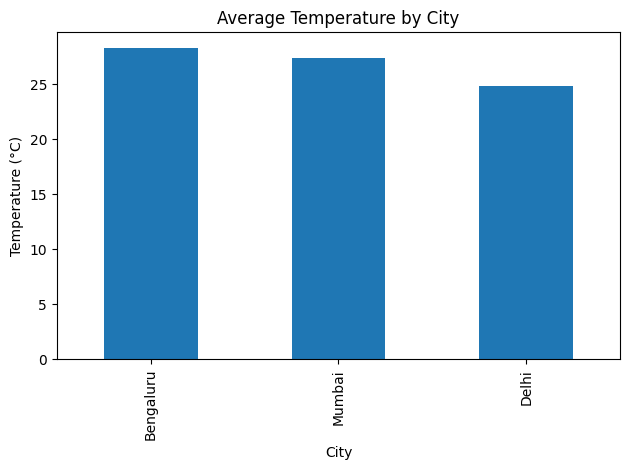

In [17]:
# Plot average temp by city
if avg_temp is not None:
    ax = avg_temp.plot(kind='bar')
    ax.set_title('Average Temperature by City')
    ax.set_ylabel('Temperature (°C)')
    ax.set_xlabel('City')
    plt.tight_layout()
    plt.show()
else:
    print('No average temperature data available to plot.')

## 9) Save cleaned dataset (optional)

Save the cleaned and imputed dataset for further use.

In [18]:
# Save cleaned dataset
df.to_csv('weather_cleaned.csv', index=False)
print('Saved weather_cleaned.csv (rows:', len(df), ')')

Saved weather_cleaned.csv (rows: 45 )
